In [1]:
# Import pandas and numpy
import pandas as pd
import numpy as np

# Import seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Import stats from scipy for inferential statistics
from scipy import stats

# Import LabelEncoder from sklearn.preprocessing
from sklearn.preprocessing import LabelEncoder

### Exploratory Data Analysis

The purpose of this notebook will be to dive into the data to develop insights and generate visualizations that will relay important factors for building the model.

In [2]:
# Import the merged training data
train_df = pd.read_csv('./Intermediate_Data/merged_train.csv', encoding='utf-8', index_col=0)

In [3]:
# Load the head of the dataframe
train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,...,TOTAL_CLOSED,CLOSED_CREDIT,MONTHS_BALANCE,SK_DPD,NET_PAID,PREV_CREDIT,DAYS_DECISION,DAYS_TERMINATION,NET_PAYMENT,PAYMENT_TIME
0,100002,1,Cash loans,Y,0,202500.0,406597.5,24700.5,351000.0,0,...,383067.0,6.0,0.0,0.0,0.0,3402045.0,-606.0,-17.0,0.000,-388.0
1,100003,0,Cash loans,N,0,270000.0,1293502.5,35698.5,1129500.0,1,...,207400.5,3.0,0.0,0.0,0.0,10159641.0,-746.0,-527.0,0.000,-179.0
2,100004,0,Revolving loans,Y,0,67500.0,135000.0,6750.0,135000.0,0,...,189037.8,2.0,0.0,0.0,0.0,60318.0,-815.0,-714.0,0.000,-23.0
3,100006,0,Cash loans,Y,0,135000.0,312682.5,29686.5,297000.0,0,...,0.0,0.0,-1.0,0.0,0.0,3745395.0,-181.0,0.0,0.000,-310.0
4,100007,0,Cash loans,Y,0,121500.0,513000.0,21865.5,513000.0,0,...,146250.0,1.0,0.0,0.0,0.0,9733149.0,-374.0,0.0,-29857.365,-240.0


In [4]:
# Load the info
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 44 columns):
SK_ID_CURR                    307511 non-null int64
TARGET                        307511 non-null int64
NAME_CONTRACT_TYPE            307511 non-null object
FLAG_OWN_REALTY               307511 non-null object
CNT_CHILDREN                  307511 non-null int64
AMT_INCOME_TOTAL              307511 non-null float64
AMT_CREDIT                    307511 non-null float64
AMT_ANNUITY                   307511 non-null float64
AMT_GOODS_PRICE               307511 non-null float64
NAME_TYPE_SUITE               307511 non-null int64
NAME_INCOME_TYPE              307511 non-null object
NAME_EDUCATION_TYPE           307511 non-null object
NAME_FAMILY_STATUS            307511 non-null object
NAME_HOUSING_TYPE             307511 non-null object
REGION_POPULATION_RELATIVE    307511 non-null float64
DAYS_BIRTH                    307511 non-null int64
DAYS_EMPLOYED                 307511 non-

From the info, it looks like the proper datatypes that we want wasn't properly loaded over. We can repeat the process here.
{'object': 'category',
'bool': 'category}

There appears to be no new null values so I won't have to worry about that here.

In [5]:
# First let's make a list with all the columns with object dtype
LABELS = [col for col in train_df if train_df[col].dtype == 'object']

# To that list, I'll manually append the VALID_MOBILE column
LABELS.append('VALID_MOBILE')

# Sanity check for proper amount of columns
assert len(LABELS) == 7

In [6]:
# Iterate over the list of labels and convert each datatype to category
for col in LABELS:
    train_df[col] = train_df[col].astype('category')

Since all the datatypes have been properly converted, I will first note which columns are meant to be numerical and which ones are meant to be categorical. Note that the LABELS list are missing a couple of categorical columns with dtype int64

Note that some of the categorical columns will be kept as int64 instead of being converted to dtype category. This is because I can apply to the OneHotEncoder on these, and the LabelEncoder on the category datatypes.

In [7]:
# Define the numerical columns. All the dtype float64s are numerical columns
NUMERICAL = [col for col in train_df if train_df[col].dtype == 'float64']

# I'll define the additional numerical columns here
ADD_NUMERICAL = ['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DOCUMENTS']

# Define the complete numerical list
NUMERICAL += ADD_NUMERICAL

# Sanity check
assert len(NUMERICAL) == (len([col for col in train_df if train_df[col].dtype == 'float64']) + len(ADD_NUMERICAL))

In [8]:
# Define the categorical columns. All columns not found in the NUMERICAL list
CATEGORICAL = [col for col in train_df if col not in NUMERICAL]

# Sanity check to make sure all columns have been categorized
assert len(NUMERICAL) + len(CATEGORICAL) == len(train_df.columns)

### Numerical Columns
I will start my analysis with the numerical columns. I'll start by checking for high correlation between each variable to check for multicollinearity. If I find any, I will either pool them together, or select a feature to remove.

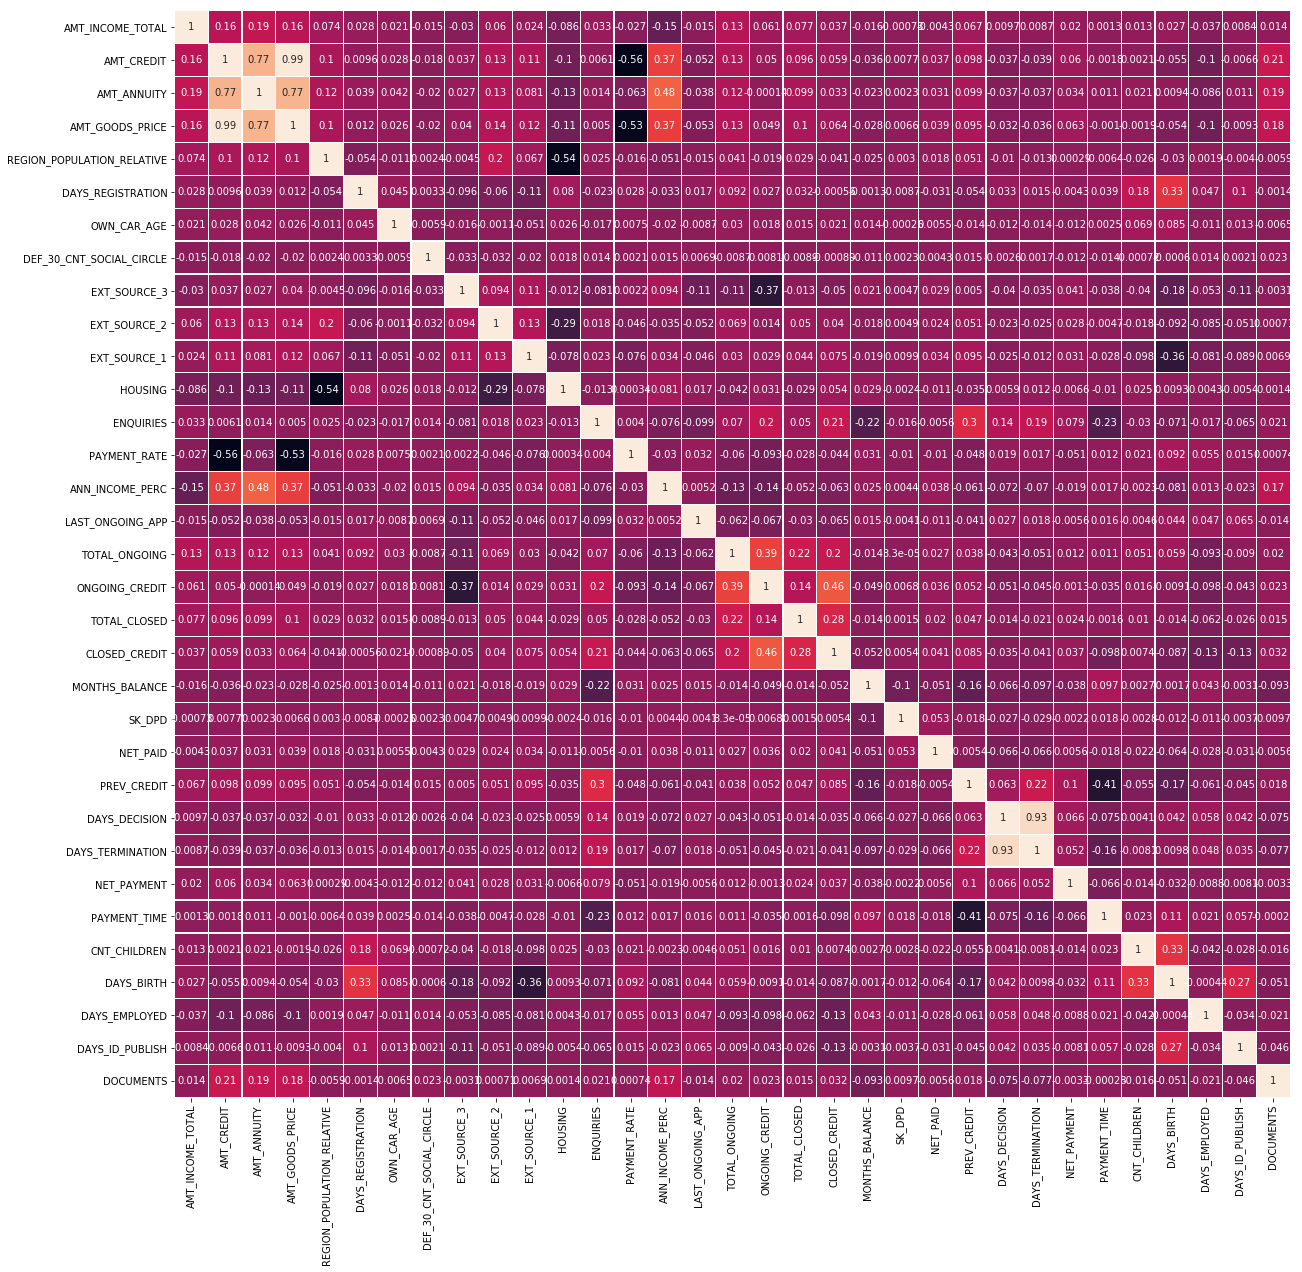

In [9]:
# Plot the correlations on a heatmap 

# Define the sparse matrix
num_corr = train_df[NUMERICAL].corr()

# Define the figure
figure, ax = plt.subplots(figsize=(20,20))
sns.heatmap(num_corr, annot=True, linewidths=0.2, cbar=False, ax=ax)

From the heatmap, we can see some interesting connections.

Positive correlations (only > 0.35 mentioned):

The most visible are the correlations between AMT_ANNUITY, AMT_CREDIT, and AMT_GOODS_PRICE. There is a high chance there is multicollinearity here. Additionally,  I feel that it is safe to remove 2/3 of these columns as additional features have already been engineered from a combination of these.

An additional white spot is the high positive correlation between DAYS_DECISION (when last application was approved) and DAYS_TERMINATION (when last approved credit will end). Due to the high correlation, I will need to remove one of the columns.

Between ANN_INCOME_PERC and AMT_ANNUITY, there is a correlation of 0.48. This makes sense as ANN_INCOME_PERC is AMT_ANNUITY / AMT_INCOME_TOTAL. 

Similarly, there is a correlation of 0.37 between AMT_CREDIT and AMT_INCOME_PERC. This is likely due to the high correlation between AMT_CREDIT and AMT_ANNUITY.

There is also a positive correlation (0.46) between ONGOING_CREDIT and CLOSED_CREDIT. This simply suggests that clients with more closed credit accounts will tend to have more ongoing accounts. Both columns will be kept for now. 

Similarly, there is a positive correlation (0.39) between ONGOING_CREDIT and TOTAL_ONGOING. This makes sense since ONGOING_CREDIT is the total count of ongoing accounts, whereas TOTAL_ONGOING is the amount. The two are complementary variables. Both variables will be kept for now.

Negative Correlations (only < -0.35 mentioned):

PAYMENT_RATE (AMT_ANNUITY / AMT_CREDIT) is correlated to AMT_CREDIT (-0.56) and AMT_TOTAL_GOODS (-0.53). This makes sense as PAYMENT_RATE was derived from AMT_CREDIT, and AMT_TOTAL_GOODS and AMT_CREDIT are highly correlated.

There is also a negative correlation (-0.54) between REGION_POPULATION_RELATIVE and HOUSING. This could make practical sense as population dense areas are usually areas with cheaper rent due to smaller property and lower-income areas. In that case, these two columns can offer the same form of information. Since this correlation isn't too strong, I will keep both columns for now.

There also appears to be a negative correlation (-0.41) between PAYMENT_TIME and PREV_CREDIT. Therefore, this suggests that clients who have finished paying off larger loans are more likely to make late installment payments. Since these two offer different information and the correlation isn't too strong, I will keep both columns for now.

Between ONGOING_CREDIT and EXT_SOURCE_3, there is a negative correlation of -0.37. As I'm not exactly sure what this represents, I will leave this untouched, but noted.

Between EXT_SOURCE_1 and DAYS_BIRTH, there is a negative correlation of -0.36. As I'm not exactly sure what this represents, I will leave this untouched, but noted.

From the positive correlations, I need to address the AMT_CREDIT, AMT_ANNUITY, and AMT_GOODS_PRICE. I will be removing AMT_GOODS_PRICE as it has the highest correlation and it offers information about the application, not the client. I will leave the remaining two, but will flag them for future removal during the deployment of the model.

Additionally, I need to address the correlation between DAYS_DECISION and DAYS_TERMINATION. I will be removing DAYS_DECISION as I feel that DAYS_TERMINATION offers more information about the client.

In [10]:
# Drop the DAYS_DECISION and AMT_GOODS_PRICE columns
mid_train_df = train_df.drop(['DAYS_DECISION', 'AMT_GOODS_PRICE'], axis=1)

# Sanity check to make sure the column has been dropped
assert 'DAYS_DECISION' not in mid_train_df.columns

In [11]:
# Additionally, let's update the list of numerical columns to remove DAYS_DECISION
NUMERICAL.remove('DAYS_DECISION')

# Remove the AMT_GOODS_PRICE
NUMERICAL.remove('AMT_GOODS_PRICE')

Text(0.5,1,'ONGOING_CREDIT vs. TOTAL_ONGOING')

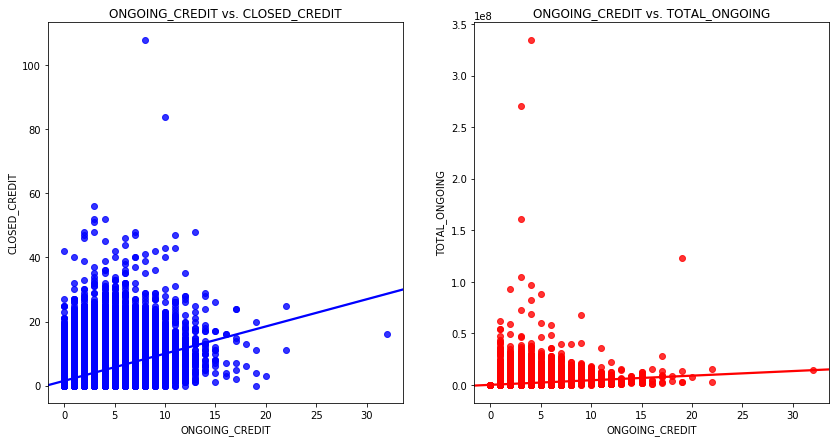

In [12]:
# Let's explore the some of the other correlations with scatter plots

# Let's plot the positive correlations
# Define the figure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))

# Plot the ONGOING_CREDIT and CLOSED_CREDIT
sns.regplot(mid_train_df['ONGOING_CREDIT'], mid_train_df['CLOSED_CREDIT'], ax=ax1, color='b')
ax1.set_title('ONGOING_CREDIT vs. CLOSED_CREDIT')

# Plot the ONGOING_CREDIT and TOTAL_ONGOING
sns.regplot(mid_train_df['ONGOING_CREDIT'], mid_train_df['TOTAL_ONGOING'], ax=ax2,color='r')
ax2.set_title('ONGOING_CREDIT vs. TOTAL_ONGOING')

Taking a closer look at the plotted correlations, it appears that the plotted regression line is a poor fit to the data. As a result, I will be keep all the columns noted in the positive correlations.

Text(0.5,1,'PAYMENT_TIME vs. PREV_CREDIT')

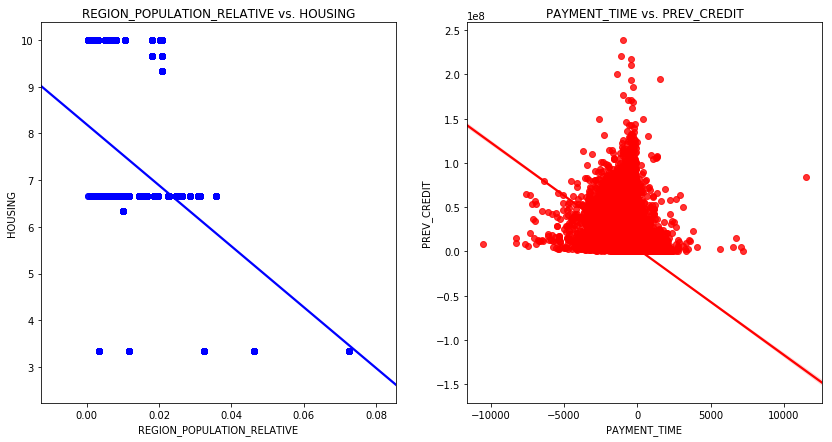

In [13]:
# Let's plot the negative correlations

# Define the figure
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 7))

# Plot the REGION_POPULATION_RELATIVE and HOUSING
sns.regplot(mid_train_df['REGION_POPULATION_RELATIVE'], mid_train_df['HOUSING'], ax=ax1, color='b')
ax1.set_title('REGION_POPULATION_RELATIVE vs. HOUSING')

# Plot the PAYMENT_TIME and PREV_CREDIT
sns.regplot(mid_train_df['PAYMENT_TIME'], mid_train_df['PREV_CREDIT'], ax=ax2,color='r')
ax2.set_title('PAYMENT_TIME vs. PREV_CREDIT')

Upon closer inspection of the plotted correlations, it appears that plotted regression line is a poor fit to the PAYMENT_TIME vs. PREV_CREDIT data. Additionally, it does appear that higher rated housing is commonly found in less-dense areas. However, the negative correlation could be due to the set of extreme points (high population and low housing score). As a result, I will be keep all the columns noted in the negative correlations.

In [14]:
mid_train_df[['REGION_POPULATION_RELATIVE', 'HOUSING']].sort_values('REGION_POPULATION_RELATIVE', ascending=False).head()

,REGION_POPULATION_RELATIVE,HOUSING
223701,0.072508,3.333333
294650,0.072508,3.333333
10496,0.072508,3.333333
294671,0.072508,3.333333
10500,0.072508,3.333333


Now I'll try to single out the numerical variable that best predicts the risk of default. I'll be doing this via boxplots.

### Recall that this is an unbalanced dataframe. Expect to see more 0's than 1's for targets

In [15]:
# # Define a function that will plot boxplots of variables against the target
# def draw_boxplot(variable):
#     sns.boxplot(mid_train_df['TARGET'], variable)
#     plt.show()

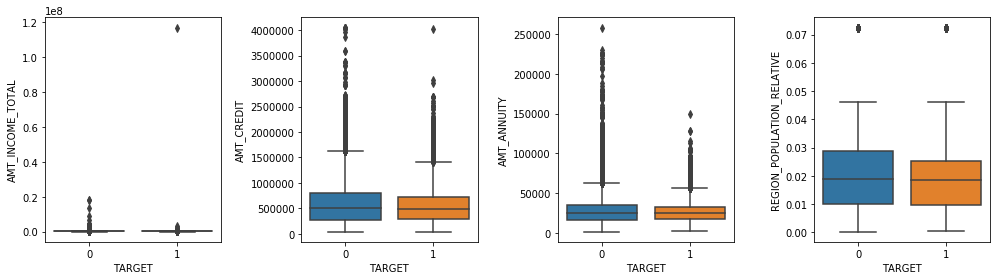

In [16]:
# Let's plot all the boxplots. I'll do 4 at a time.
fig, ax=plt.subplots(ncols=4, figsize=(14,4))

for i in range(4):
    sns.boxplot(mid_train_df['TARGET'], mid_train_df[NUMERICAL[i]], ax=ax[i])

plt.tight_layout()

Potential relationships:

AMT_INCOME_TOTAL: Increased income = reduced risk of default

AMT_ANNUITY: Difficuly to say

AMT_CREDIT: Difficult to say

REGION_POPULATION_RELATIVE: N/A

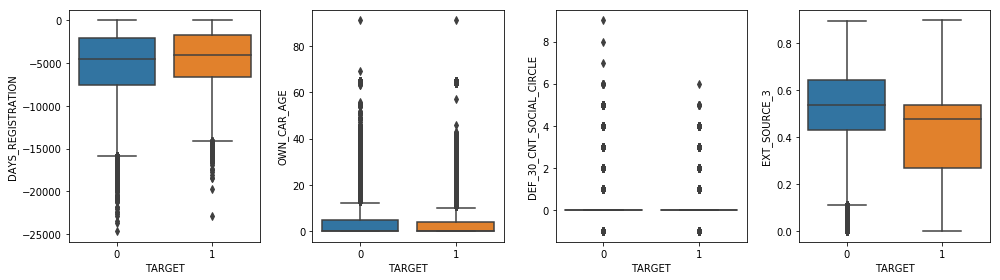

In [17]:
# Next 4
fig, ax=plt.subplots(ncols=4, figsize=(14,4))

for i in range(4):
    sns.boxplot(mid_train_df['TARGET'], mid_train_df[NUMERICAL[i+4]], ax=ax[i])

plt.tight_layout()

Potential relationships:

DAYS_REGISTRATION: Difficult to say

OWN_CAR_AGE: Difficult to say

DEF_30_CNT_SOCIAL_CIRCLE: Difficult to say

EXT_SOURCE_3: Increased score for non-targets

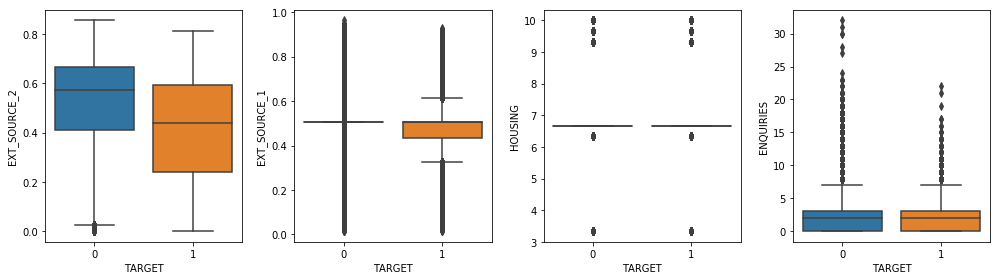

In [18]:
# Next 4
fig, ax=plt.subplots(ncols=4, figsize=(14,4))

for i in range(4):
    sns.boxplot(mid_train_df['TARGET'], mid_train_df[NUMERICAL[i+8]], ax=ax[i])

plt.tight_layout()

Potential relationships:

EXT_SOURCE_2 = Increased score for non-targets

EXT_SOURCE_1 = Difficult to say

HOUSING = Difficult to say

ENQUIRIES = Difficult to say

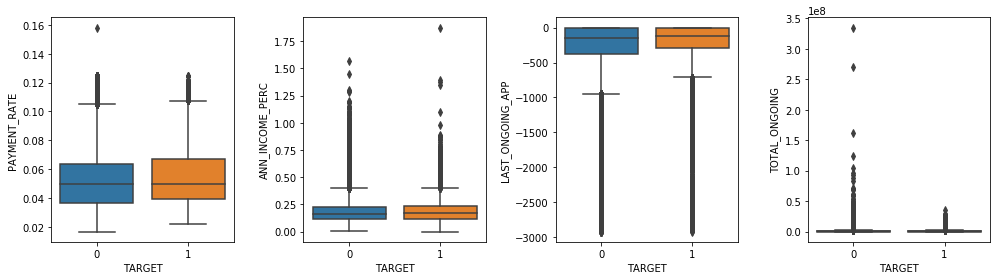

In [19]:
# Next 4
fig, ax=plt.subplots(ncols=4, figsize=(14,4))

for i in range(4):
    sns.boxplot(mid_train_df['TARGET'], mid_train_df[NUMERICAL[i+12]], ax=ax[i])

plt.tight_layout()

Potential relationships:

PAYMENT_RATE = lower for targets???

ANN_INCOME_PERC = difficult to say

LAST_ONGOING_APP = difficult to say

TOTAL_ONGOING: Increased total credit amount ongoing = reduced risk

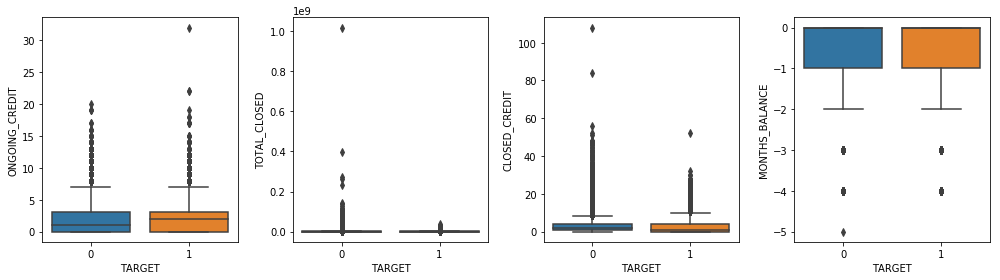

In [20]:
# Next 4
fig, ax=plt.subplots(ncols=4, figsize=(14,4))

for i in range(4):
    sns.boxplot(mid_train_df['TARGET'], mid_train_df[NUMERICAL[i+16]], ax=ax[i])

plt.tight_layout()

Potential relationships:

ONGOING_CREDIT: Difficult to say, median shows that most of low risk clients have more ongoing accounts

TOTAL_CLOSED: Increased total closed accounts = reduced risk

CLOSED_CREDIT: Increased closed credit accounts = reduced risk

MONTHS_BALANCE: N/A

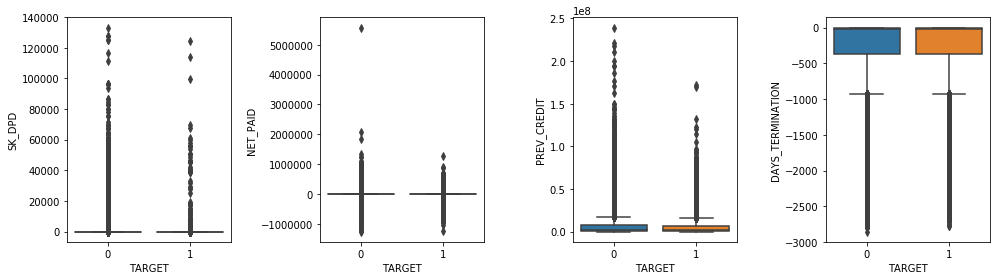

In [21]:
# Next 4
fig, ax=plt.subplots(ncols=4, figsize=(14,4))

for i in range(4):
    sns.boxplot(mid_train_df['TARGET'], mid_train_df[NUMERICAL[i+20]], ax=ax[i])

plt.tight_layout()

Potential relationships:

SK_DPD: strange relationship here as SK_DPD represents length of missed payments

NET_PAID: N/A

PREV_CREDIT: increased amount of previous approved application = reduced risk of default

DAYS_TERMINATION: Difficult to say

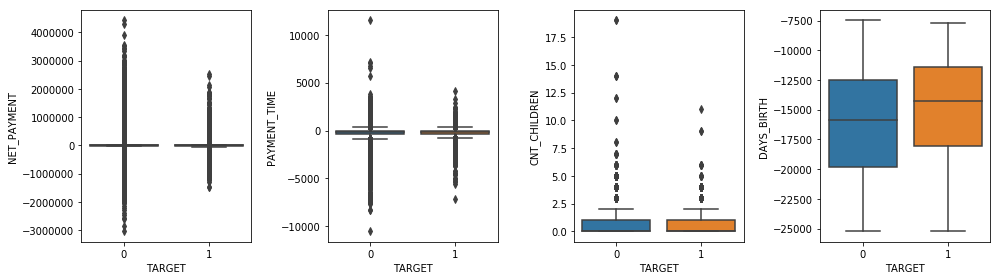

In [22]:
# Next 4
fig, ax=plt.subplots(ncols=4, figsize=(14,4))

for i in range(4):
    sns.boxplot(mid_train_df['TARGET'], mid_train_df[NUMERICAL[i+24]], ax=ax[i])

plt.tight_layout()

NET_PAYMENT: N/A, the extremes are less likely to default?

PAYMENT_TIME: N/A, the extremes are less likely to default?

CNT_CHILDREN: N/A

DAYS_BIRTH: Increased age = lower risk of default

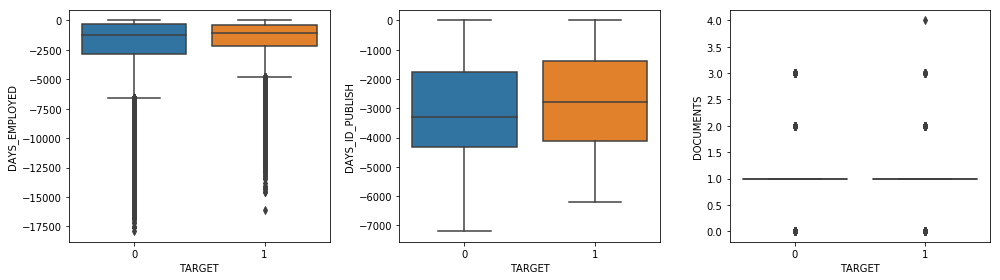

In [23]:
# Last 3
fig, ax=plt.subplots(ncols=3, figsize=(14,4))

for i in range(3):
    sns.boxplot(mid_train_df['TARGET'], mid_train_df[NUMERICAL[i+28]], ax=ax[i])

plt.tight_layout()

DAYS_EMPLOYED: Longer length of employment = lower risk of default

DAYS_ID_PUBLISH: Increased amount of time without change in identity document = lower risk of default
    
DOCUMENTS: N/A

### Note that a lot of the numerical columns are skewed

Since there are a lot of entries that could be considered "outliers", I did not want to remove them. Instead, I will be scaling them with MinMaxScaler later in the model building notebook.

##### Since the visualizations are obscure, I wouldn't feel safe interpreting correlations. I will use some inferential statistics to address this.

In [24]:
# # Define a list containing all the numerical variables with potential relationships to the target
# RELA_NUMERICAL = ['AMT_INCOME_TOTAL', 'DAYS_REGISTRATION', 'TOTAL_ONGOING', 'ONGOING_CREDIT',
#                   'TOTAL_CLOSED', 'CLOSED_CREDIT', 'SK_DPD', 'PREV_CREDIT']

In [25]:
# Define the dataframe with target value 0
low_train = mid_train_df[mid_train_df['TARGET'] == 0]

# Define the dataframe with target value 1
high_train = mid_train_df[mid_train_df['TARGET'] == 1]

I'll be testing the statistical difference between the two groups for each listed numerical variable. 

#### Difference between target and non-target clients relative to each variable (p < 0.05):
Null Hypothesis: Both groups are the same

Alternate Hypothesis: The two groups are statistically different from each othr

I will be using two-sided t-test for my testing.

In [26]:
# # Perform the t-test on the visibly different numerical columns
# for col in RELA_NUMERICAL:
#     t_score=stats.ttest_ind(low_train[col], high_train[col])
#     print ('T-score for {}: {}'.format(col, t_score))

It appears as if all of the listed columns except SK_DPD show significant difference between the targets and non-targets. However I must note that this could be attributed to the unbalanced data.

I will perform the same test to all the numerical columns to see how they fare relative to the visibly different numerical columns.

In [27]:
# Perform the t-test on ALL the numerical columns
for col in NUMERICAL:
    t_score=stats.ttest_ind(low_train[col], high_train[col])
    print ('T-score for {}: {}'.format(col, t_score))

T-score for AMT_INCOME_TOTAL: Ttest_indResult(statistic=2.227471611314488, pvalue=0.02591649183210784)
T-score for AMT_CREDIT: Ttest_indResult(statistic=16.848601925306788, pvalue=1.1474602724788813e-63)
T-score for AMT_ANNUITY: Ttest_indResult(statistic=7.106823474053646, pvalue=1.1900032937528078e-12)
T-score for REGION_POPULATION_RELATIVE: Ttest_indResult(statistic=20.658074162430665, pvalue=9.582701565109158e-95)
T-score for DAYS_REGISTRATION: Ttest_indResult(statistic=-23.297060520387824, pvalue=6.036553454565233e-120)
T-score for OWN_CAR_AGE: Ttest_indResult(statistic=-1.2673108809192632, pvalue=0.20504511109857326)
T-score for DEF_30_CNT_SOCIAL_CIRCLE: Ttest_indResult(statistic=-18.656448042011604, pvalue=1.2357417789095614e-77)
T-score for EXT_SOURCE_3: Ttest_indResult(statistic=87.51736021238897, pvalue=0.0)
T-score for EXT_SOURCE_2: Ttest_indResult(statistic=90.05350588929981, pvalue=0.0)
T-score for EXT_SOURCE_1: Ttest_indResult(statistic=55.10617435219667, pvalue=0.0)
T-sco

It looks like the only columns that DID NOT show statistical differences are:
OWN_CAR_AGE, ENQUIRIES, SK_DPD, DAYS_TERMINATION

It is necessary to perform further statistical testing to ensure of these relationships. I will utilize bootstrap sampling as well as the frequentist support to build a confidence interval.

The frequentist approach supports that OWN_CAR_AGE, ENQUIRIES, SK_DPD, and DAYS_TERMINATION are poor predictors of the the target variable.

In [28]:
# First we'll check if the difference is significant. (alpha = 0.05)

# Iterate over values in the NUMERICAL list
for col in NUMERICAL:
    
    # Define the empirical difference between the means of the two groups
    empirical_diff = abs(np.mean(low_train[col]) - np.mean(high_train[col]))
    
    # Concatenate the two groups
    concat_data = np.concatenate((low_train[col], high_train[col]))

    # Create 100 instances in an empty array
    permutated_repl = np.empty(100)

    # Perform 100 loops
    for i in range(100):
        
        # Randomly mix the concatenated data
        permutated_data = np.random.permutation(concat_data)
        
        # Separate the permutated data to low and high data
        low_data = permutated_data[:len(low_train)]
        high_data = permutated_data[len(low_train):]
        
        # Define an instance in the empty array with the new empirical difference
        permutated_repl[i] = abs(np.mean(low_data) - np.mean(high_data))

    p_value = sum(permutated_repl >= empirical_diff) / len(permutated_repl)
    print ('{} p-value: {}'.format(col, p_value))

AMT_INCOME_TOTAL p-value: 0.07
AMT_CREDIT p-value: 0.0
AMT_ANNUITY p-value: 0.0
REGION_POPULATION_RELATIVE p-value: 0.0
DAYS_REGISTRATION p-value: 0.0
OWN_CAR_AGE p-value: 0.17
DEF_30_CNT_SOCIAL_CIRCLE p-value: 0.0
EXT_SOURCE_3 p-value: 0.0
EXT_SOURCE_2 p-value: 0.0
EXT_SOURCE_1 p-value: 0.0
HOUSING p-value: 0.0
ENQUIRIES p-value: 0.11
PAYMENT_RATE p-value: 0.0
ANN_INCOME_PERC p-value: 0.0
LAST_ONGOING_APP p-value: 0.0
TOTAL_ONGOING p-value: 0.0
ONGOING_CREDIT p-value: 0.0
TOTAL_CLOSED p-value: 0.0
CLOSED_CREDIT p-value: 0.0
MONTHS_BALANCE p-value: 0.01
SK_DPD p-value: 0.71
NET_PAID p-value: 0.0
PREV_CREDIT p-value: 0.0
DAYS_TERMINATION p-value: 0.72
NET_PAYMENT p-value: 0.0
PAYMENT_TIME p-value: 0.0
CNT_CHILDREN p-value: 0.0
DAYS_BIRTH p-value: 0.0
DAYS_EMPLOYED p-value: 0.0
DAYS_ID_PUBLISH p-value: 0.0
DOCUMENTS p-value: 0.0


In [29]:
# Define a function for bootstrapping
def bootstrap(cat, num):
    '''Returns [num] bootstrap means of specified category'''
    # Create [num] instances of empty arrays for low_train, high_train to contain the bootstrap samples
    low_train_bootstrap = np.empty(num)
    high_train_bootstrap = np.empty(num)

    for i in range(num):
        # Define the bootstrap samples and store them in the empty arrays 
        low_train_bootstrap[i] = np.mean(np.random.choice(low_train[cat], len(low_train)))
        high_train_bootstrap[i] = np.mean(np.random.choice(high_train[cat], len(high_train)))
        
    return low_train_bootstrap, high_train_bootstrap

In [30]:
# Iterate over the values in the NUMERICAL list
for col in NUMERICAL:
    
    # Define 100 bootstrap samples for each category
    low_train_repl, high_train_repl = bootstrap(col, 100)
    
    # Define the confidence intervals
    confidence_interval_low = np.percentile(low_train_repl, [2.5, 97.5])
    confidence_interval_high = np.percentile(high_train_repl, [2.5, 97.5])
    
    # Print the results
    print ('\n{}:'.format(col))
    print ('95% Confidence Interval for Low Data:', confidence_interval_low)
    print ('95% Confidence interval for High Data:', confidence_interval_high)


AMT_INCOME_TOTAL:
95% Confidence Interval for Low Data: [168755.94571415 169507.40490348]
95% Confidence interval for High Data: [160420.13163897 175652.28854683]

AMT_CREDIT:
95% Confidence Interval for Low Data: [601084.64099146 604473.61203363]
95% Confidence interval for High Data: [553710.37610121 562180.02538369]

AMT_ANNUITY:
95% Confidence Interval for Low Data: [27117.01496201 27219.84330494]
95% Confidence interval for High Data: [26317.7210574  26628.09134139]

REGION_POPULATION_RELATIVE:
95% Confidence Interval for Low Data: [0.02096796 0.02107174]
95% Confidence interval for High Data: [0.01900815 0.01925305]

DAYS_REGISTRATION:
95% Confidence Interval for Low Data: [-5042.83808725 -5019.48078989]
95% Confidence interval for High Data: [-4525.1007422  -4453.95501813]

OWN_CAR_AGE:
95% Confidence Interval for Low Data: [4.0638859 4.1274353]
95% Confidence interval for High Data: [4.04563041 4.28682779]

DEF_30_CNT_SOCIAL_CIRCLE:
95% Confidence Interval for Low Data: [0.133

In [31]:
# # Iterate over the values in the NUMERICAL list
# for col in NUMERICAL:
    
#     # Define the empirical difference between the means of the two groups
#     empirical_diff = abs(np.mean(low_train[col]) - np.mean(high_train[col]))

#     # Create a 100 instances of empty arrays for low_train, high_train, and diff_of_mean to contain the bootstrap samples
#     low_train_repl = np.empty(100)
#     high_train_repl = np.empty(100)
#     diff_of_mean_repl = np.empty(100)

#     for i in range(100):
#         # Define the bootstrap samples and store them in the empty arrays 
#         low_train_repl[i] = np.mean(np.random.choice(low_train[col], len(low_train)))
#         high_train_repl[i] = np.mean(np.random.choice(high_train[col], len(high_train)))
#         diff_of_mean_repl[i] = abs(low_train_repl[i] - high_train_repl[i])

#     # Define the confidence intervals
#     confidence_interval_low = np.percentile(low_train_repl, [2.5, 97.5])
#     confidence_interval_high = np.percentile(high_train_repl, [2.5, 97.5])
    
#     # Count the instances with extreme empirical differences
# #     total_diff = sum(diff_of_mean_repl >= empirical_diff) / len(diff_of_mean_repl)
    
#     # Print the results
#     print ('\n{}:'.format(col))
#     print ('95% Confidence Interval for Low Data:', confidence_interval_low)
#     print ('95% Confidence interval for High Data:', confidence_interval_high)
# #     print ('Occurence greater or equal to empirical diff:', total_diff)

The columns with non-overlapping 95% confidence intervals between the target and non-target data can be considered as good predictors of the target.

Interestingly, there is a small range for total income that fits a large amount of the non-target data. However, the target data has a very large range that encompasses this smaller range.

For my model, I will attempt to use all of the numerical columns. However, I will also remove OWN_CAR_AGE, ENQUIRIES, SK_DPD, and DAYS_TERMINATION since they may do more bad than good.

### Let's explore some of the more interesting numerical columns.

It looks like the most interesting numerical columns is AMT_INCOME_TOTAL and NET_PAYMENT. The remainder of the columns tagged as good predictors simply have non-overlapping 95% confidence intervals. I will visually explore one of them for good measure.

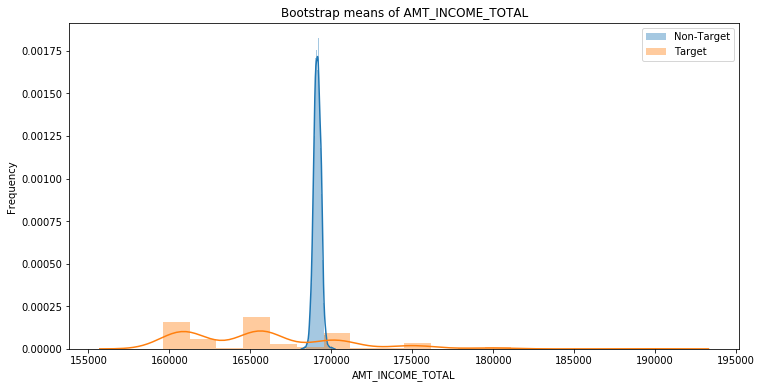

In [32]:
# Plot the mean distribution of AMT_INCOME_TOTAL for both groups from the bootstrapping.

# Define the figure that both plots will be on
figure = plt.figure(figsize=(12, 6))

# Plot both the bootstrap samples

low_train_repl, high_train_repl = bootstrap('AMT_INCOME_TOTAL', 1000)

# Plot the samples
sns.distplot(low_train_repl, label='Non-Target')
sns.distplot(high_train_repl, label='Target')

# Add the xlabel, ylabel, and title
plt.xlabel('AMT_INCOME_TOTAL')
plt.ylabel('Frequency')
plt.title('Bootstrap means of AMT_INCOME_TOTAL')
plt.legend()

In the target data, there is a huge distribution of income ranges and multiple peaks despite taking the mean of 1000 bootstrap samples. In comparison, the non-target data has a normal distribution at a very tight range.

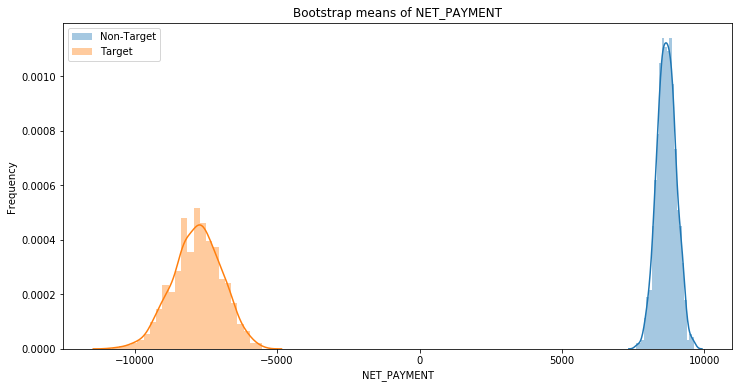

In [33]:
# Plot the mean distribution of NET_PAYMENT for both groups from the bootstrapping.

# Define the figure that both plots will be on
figure = plt.figure(figsize=(12, 6))

# Plot both the bootstrap samples

low_train_repl, high_train_repl = bootstrap('NET_PAYMENT', 1000)

# Plot the samples
sns.distplot(low_train_repl, label='Non-Target')
sns.distplot(high_train_repl, label='Target')

# Add the xlabel, ylabel, and title
plt.xlabel('NET_PAYMENT')
plt.ylabel('Frequency')
plt.title('Bootstrap means of NET_PAYMENT')
plt.legend()

For this NET_PAYMENT, this column had the most extreme non-overlapping 95% confidence interval. It appears that the target group usually had negative net payments (paid less than requested on their payment schedule).

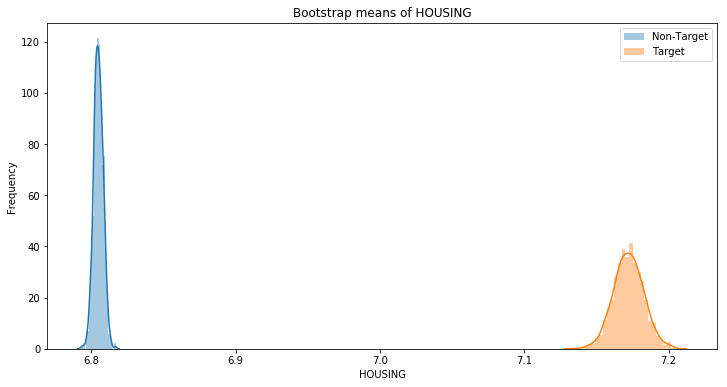

In [34]:
# Plot the mean distribution of HOUSING for both groups from the bootstrapping.

# Define the figure that both plots will be on
figure = plt.figure(figsize=(12, 6))

# Plot both the bootstrap samples

low_train_repl, high_train_repl = bootstrap('HOUSING', 1000)

# Plot the samples
sns.distplot(low_train_repl, label='Non-Target')
sns.distplot(high_train_repl, label='Target')

# Add the xlabel, ylabel, and title
plt.xlabel('HOUSING')
plt.ylabel('Frequency')
plt.title('Bootstrap means of HOUSING')
plt.legend()

This plot is representative of the rest of the numerical columns with non-overlapping 95% confidence intervals. The plot appears similar to the NET_PAYMENT histogram with two distinct, normal distributed peaks.

Let's plot some of the distributions from the non-bootstrap data.

In [35]:
low_train['EXT_SOURCE_3'].shape

(282686,)

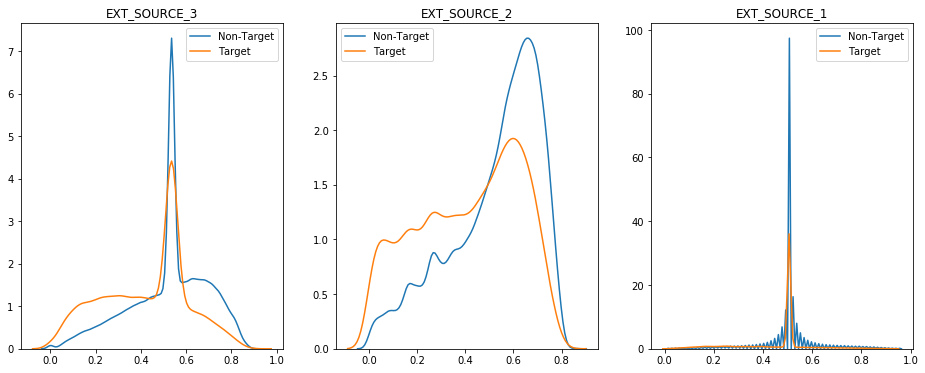

In [36]:
# Let's first look at EXT_SOURCES

# Define the figure that both plots will be on
figure, ax = plt.subplots(ncols=3, figsize=(16, 6))

EXT_SOURCE = ['EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1']

# Iterate over a list of the EXT_SOURCE's and plot kdeplots
for col in range(len(EXT_SOURCE)):
    sns.kdeplot(low_train[EXT_SOURCE[col]], ax=ax[col], label='Non-Target').set_title(EXT_SOURCE[col])
    sns.kdeplot(high_train[EXT_SOURCE[col]], ax=ax[col], label='Target')

For EXT_SOURCE 3 and EXT_SOURCE 2, the target population was scored noticably lower.

### Categorical Columns
Similarly to numerical columns, let's explore these a little with some t-tests and overlapping confidence intervals.

At this point, I could use the LabelEncoder of sklearn.preprocessing to convert these to numerical values. However, the use of numerical values with non-binary categories can make the visualization confusing.

Since t-tests only works with numerical data, I will need to convert the binary categories to 0's and 1's for analysis. I will not be performing these tests on the non-binary categories.

For my analysis, I will applying the LabelEncoder directly onto the training data as I will need these labels as values later for the development of the model.

In [37]:
mid_train_df[CATEGORICAL].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REG_REGION_NOT_LIVE_REGION,VALID_MOBILE
0,100002,1,Cash loans,Y,0,Working,Secondary / secondary special,Single / not married,House / apartment,0,True
1,100003,0,Cash loans,N,1,State servant,Higher education,Married,House / apartment,0,True
2,100004,0,Revolving loans,Y,0,Working,Secondary / secondary special,Single / not married,House / apartment,0,True
3,100006,0,Cash loans,Y,0,Working,Secondary / secondary special,Civil marriage,House / apartment,0,True
4,100007,0,Cash loans,Y,0,Working,Secondary / secondary special,Single / not married,House / apartment,0,True


In [38]:
# Create new lists with binary and non-binary categories. Leave out the SK_ID_CURR and TARGET from the columns

# Define the binary categories
BINARY_CAT = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'REG_REGION_NOT_LIVE_REGION', 'VALID_MOBILE']

# Define the non-binary categories
NON_BIN_CAT = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']

In [39]:
mid_train_df[BINARY_CAT].dtypes

NAME_CONTRACT_TYPE            category
FLAG_OWN_REALTY               category
NAME_TYPE_SUITE                  int64
REG_REGION_NOT_LIVE_REGION       int64
VALID_MOBILE                  category
dtype: object

In [40]:
# Instantiate the LabelEncoder
labEncode = LabelEncoder()

# Convert the dtype category columns in BINARY_CAT to numeric data using LabelEncoder
for col in BINARY_CAT:
    if mid_train_df[col].dtype != 'int64':
        mid_train_df[col] = labEncode.fit_transform(mid_train_df[col])

Encoded values for binary categories:

NAME_CONTRACT_TYPE: {'Cash loans': 0, 'Revolving loans': 1}

FLAG_OWN_REALTY: {'Y': 1, 'N': 0}

VALID_MOBILE: {'True': 1, 'False': 0} 

In [41]:
# Split the data into target and non-target dataframes

# Define the dataframe with target value 0
low_train = mid_train_df[mid_train_df['TARGET'] == 0]

# Define the dataframe with target value 1
high_train = mid_train_df[mid_train_df['TARGET'] == 1]

In [42]:
# Perform the t-test on ALL the binary category columns
for col in BINARY_CAT:
    t_score=stats.ttest_ind(low_train[col], high_train[col])
    print ('T-score for {}: {}'.format(col, t_score))

T-score for NAME_CONTRACT_TYPE: Ttest_indResult(statistic=17.141043593261152, pvalue=7.868765336692795e-66)
T-score for FLAG_OWN_REALTY: Ttest_indResult(statistic=3.4095602544721073, pvalue=0.0006507605126674314)
T-score for NAME_TYPE_SUITE: Ttest_indResult(statistic=4.060825910427432, pvalue=4.8911520801420354e-05)
T-score for REG_REGION_NOT_LIVE_REGION: Ttest_indResult(statistic=-3.09210413087166, pvalue=0.0019876089466520012)
T-score for VALID_MOBILE: Ttest_indResult(statistic=-0.21743986565182005, pvalue=0.8278657102685834)


In [43]:
# Iterate over the values in the NUMERICAL list
for col in BINARY_CAT:
    
    # Define the empirical difference between the means of the two groups
    empirical_diff = abs(np.mean(low_train[col]) - np.mean(high_train[col]))

    # Create a 100 instances of empty arrays for low_train, high_train, and diff_of_mean to contain the bootstrap samples
    low_train_repl = np.empty(100)
    high_train_repl = np.empty(100)
    diff_of_mean_repl = np.empty(100)

    for i in range(100):
        # Define the bootstrap samples and store them in the empty arrays 
        low_train_repl[i] = np.mean(np.random.choice(low_train[col], len(low_train)))
        high_train_repl[i] = np.mean(np.random.choice(high_train[col], len(high_train)))
        diff_of_mean_repl[i] = abs(low_train_repl[i] - high_train_repl[i])

    # Define the confidence intervals
    confidence_interval_low = np.percentile(low_train_repl, [2.5, 97.5])
    confidence_interval_high = np.percentile(high_train_repl, [2.5, 97.5])
    
    # Count the instances with extreme empirical differences
#     total_diff = sum(diff_of_mean_repl >= empirical_diff) / len(diff_of_mean_repl)
    
    # Print the results
    print ('\n{}:'.format(col))
    print ('95% Confidence Interval for Low Data:', confidence_interval_low)
    print ('95% Confidence interval for High Data:', confidence_interval_high)
#     print ('Occurence greater or equal to empirical diff:', total_diff)


NAME_CONTRACT_TYPE:
95% Confidence Interval for Low Data: [0.09697553 0.09925943]
95% Confidence interval for High Data: [0.06196073 0.06725579]

FLAG_OWN_REALTY:
95% Confidence Interval for Low Data: [0.69285683 0.69619189]
95% Confidence interval for High Data: [0.68035851 0.68950554]

NAME_TYPE_SUITE:
95% Confidence Interval for Low Data: [0.1871826  0.18987463]
95% Confidence interval for High Data: [0.17356495 0.18352467]

REG_REGION_NOT_LIVE_REGION:
95% Confidence Interval for Low Data: [0.01453017 0.01540685]
95% Confidence interval for High Data: [0.01575932 0.01895569]

VALID_MOBILE:
95% Confidence Interval for Low Data: [0.99796948 0.99827017]
95% Confidence interval for High Data: [0.99768278 0.99863041]


According to the ttest results and frequentist approach with bootstrapping, it appears that all binary categories besides VALID_MOBILE are good predictors of the target data. I see non-overlapping 95% confidence intervals as well as very low p-values which suggests that these two groups are distinctly different relative to these categories.

However, I must acknowledge that the dataset is very unbalanced which causes these to be a grey area. As a result, I will attempt my model with both the variables removed and left alone.

The binary categories show similar non-overlapping 95% confidence intervals. I will plot one of the columns as a representative of the remainder of the data.

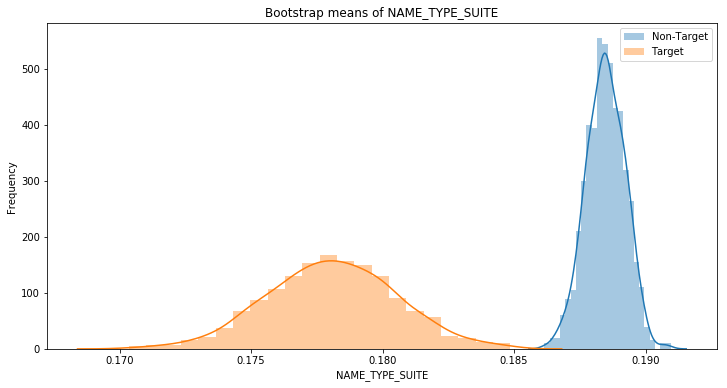

In [44]:
# Plot the mean distribution of NAME_TYPE_SUITE for both groups from the bootstrapping.

# Define the figure that both plots will be on
figure = plt.figure(figsize=(12, 6))

# Plot both the bootstrap samples

low_train_repl, high_train_repl = bootstrap('NAME_TYPE_SUITE', 1000)

# Plot the samples
sns.distplot(low_train_repl, label='Non-Target')
sns.distplot(high_train_repl, label='Target')

# Add the xlabel, ylabel, and title
plt.xlabel('NAME_TYPE_SUITE')
plt.ylabel('Frequency')
plt.title('Bootstrap means of NAME_TYPE_SUITE')
plt.legend()

It appears that the target group has a wider distribution than the non-target group in regards to if they come accompanied when applying for the credit. This plot indicates that clients that are accompanied are more likely to be in the non-target group. However, the unbalanced data could have caused this visualization.

### Remaining Data

For the remaining variables, I will not attempt to use t-test with the non-binary categorical data as it could easily misrepresent the data. I will move forward with applying preprocessing steps, particularly LabelEncoder, to the categorical data here and write the training data to a csv for work in the Modeling notebook.

In [45]:
mid_train_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,ONGOING_CREDIT,TOTAL_CLOSED,CLOSED_CREDIT,MONTHS_BALANCE,SK_DPD,NET_PAID,PREV_CREDIT,DAYS_TERMINATION,NET_PAYMENT,PAYMENT_TIME
0,100002,1,0,1,0,202500.0,406597.5,24700.5,0,Working,...,2.0,383067.0,6.0,0.0,0.0,0.0,3402045.0,-17.0,0.000,-388.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1,State servant,...,1.0,207400.5,3.0,0.0,0.0,0.0,10159641.0,-527.0,0.000,-179.0
2,100004,0,1,1,0,67500.0,135000.0,6750.0,0,Working,...,0.0,189037.8,2.0,0.0,0.0,0.0,60318.0,-714.0,0.000,-23.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,0,Working,...,0.0,0.0,0.0,-1.0,0.0,0.0,3745395.0,0.0,0.000,-310.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,0,Working,...,0.0,146250.0,1.0,0.0,0.0,0.0,9733149.0,0.0,-29857.365,-240.0


In [46]:
# Instantiate a new LabelEncoder
labEncode = LabelEncoder()

# Convert all column sin NON_BIN_CAT to numeric data using LabelEncoder
for col in NON_BIN_CAT:
    mid_train_df[col] = labEncode.fit_transform(mid_train_df[col])

In [47]:
# Check the info to make sure there are no more category dtypes
mid_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 42 columns):
SK_ID_CURR                    307511 non-null int64
TARGET                        307511 non-null int64
NAME_CONTRACT_TYPE            307511 non-null int64
FLAG_OWN_REALTY               307511 non-null int64
CNT_CHILDREN                  307511 non-null int64
AMT_INCOME_TOTAL              307511 non-null float64
AMT_CREDIT                    307511 non-null float64
AMT_ANNUITY                   307511 non-null float64
NAME_TYPE_SUITE               307511 non-null int64
NAME_INCOME_TYPE              307511 non-null int64
NAME_EDUCATION_TYPE           307511 non-null int64
NAME_FAMILY_STATUS            307511 non-null int64
NAME_HOUSING_TYPE             307511 non-null int64
REGION_POPULATION_RELATIVE    307511 non-null float64
DAYS_BIRTH                    307511 non-null int64
DAYS_EMPLOYED                 307511 non-null int64
DAYS_REGISTRATION             307511 non-null flo

In [48]:
# Sanity checks

# Ensure no rows were lost
assert len(mid_train_df) == len(train_df)

# Ensure no additional columns were removed besides DAYS_DECISIONS and AMT_GOODS_PRICE
assert len(mid_train_df.columns) == len(train_df.columns) - 2

In [49]:
# Write the dataframe to a csv for use in another notebook
mid_train_df.to_csv('./Intermediate_Data/encoded_train.csv', encoding='utf-8')